# Display clear pre-post disaster imagery

We want a plot showing the difference a disaster has made on a Caribbean island, ideallyt around an informal settlment. We will begin with trying to use Dominica and the effect of hurricane Maria end of Sept 2017

In [9]:
# Import packages
import IPython
import ipywidgets
import ipyleaflet
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import os
import tensorflow as tf
import geopandas as gpd


import descarteslabs as dl
import descarteslabs.workflows as wf
from descarteslabs.vectors import FeatureCollection, properties as p

## 1 - Sentinel before-after scene

In [24]:
m1 = wf.interactive.MapApp()
m1.center = (18.466333, -66.105721) #coordinate centre for Puerto Rico
m1.zoom = 14

#pre-disaster imagery
img = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2017-08-15', end_datetime='2017-09-15').pick_bands("red green blue")
img = img.filter(lambda img: img.properties["cloud_fraction"] <= 0.1) #filtering out the clouds
my_mosaic = img.min(axis="images")  #axis='images')
my_mosaic.visualize('before', map=m1) # scales=[(0, 1), (0, 1), (0, 1)],

#post disaster imagery
img2 = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2017-10-01', end_datetime='2017-11-01').pick_bands("red green blue")
img2 = img2.filter(lambda img: img.properties["cloud_fraction"] <= 0.7) #filtering out the clouds
my_mosaic2 = img2.min(axis="images")
my_mosaic2.visualize('after', map=m1) # scales=[(0, 1), (0, 1), (0, 1)],

m1


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


Working to try and get better cloud removal on pre- and post- imagery  (unsuccessfully)

In [25]:
m1 = wf.interactive.MapApp()
m1.center = (18.466333, -66.105721)
m1.zoom = 15

#pre-disaster imagery
img_pre = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2017-08-15', end_datetime='2017-09-15').pick_bands("red green blue cloud-mask red-edge-2 red-edge-3 red-edge-4 nir swir1 swir2")
img_pre = img_pre.filter(lambda img: img.properties["cloud_fraction"] <= 0.1)
img_pre_msk = img_pre.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1))
mos_pre = (img_pre_msk.mosaic().pick_bands("red green blue"))
mos_pre.visualize('before', map=m1) #scales=[(0, 1), (0, 1), (0, 1)],

#post disaster imagery#post disaster imagery
img_post = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2017-10-01', end_datetime='2017-11-01').pick_bands("red green blue cloud-mask red-edge-2 red-edge-3 red-edge-4 nir swir1 swir2")
img_post = img_post.filter(lambda img: img.properties["cloud_fraction"] <= 0.06)
img_post_msk = img_post.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1))
mos_post = (img_post_msk.mosaic().pick_bands("red green blue"))
mos_post.visualize('after', map=m1)

m1



`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


## 2 - Import some ground data for damage assessments

### FEMA Damage Assessment

In [18]:
# Data from FEMA -> Only seems to have for Puerto Rico because is American
g = gpd.read_file("/home/jovyan/gtc-exposure-data/damage_assessments/FEMA_Damage_Assessments_Public_20190422.gdb")

In [19]:
g.head()

,DMG_LEVEL,DMG_TYPE,ASMT_TYPE,IN_DEPTH,WIND_SPEED,PGA,ACCESS,COUNTY,STATE,FIPS,...,IMG_DATE,EVENT_NAME,EVENT_DATE,SOURCE,DIS_NUMBER,COMMENTS,LONGITUDE,LATITUDE,USNG,geometry
0,AFF,FL,MOD,NaN,UNK,None,UNK,Miami-Dade,FL,12086.0,...,None,Hurricane Irma,None,FEMA,DR-4337,None,-80.288445,25.832729,None,POINT (-80.28844116699997 25.83272840700005)
1,AFF,FL,MOD,NaN,UNK,None,UNK,Miami-Dade,FL,12086.0,...,None,Hurricane Irma,None,FEMA,DR-4337,None,-80.254799,25.792208,None,POINT (-80.25479682799994 25.79220840000005)
2,AFF,FL,MOD,NaN,UNK,None,UNK,Miami-Dade,FL,12086.0,...,None,Hurricane Irma,None,FEMA,DR-4337,None,-80.169319,25.692503,None,POINT (-80.16931667999995 25.69250245500007)
3,AFF,FL,MOD,NaN,UNK,None,UNK,Miami-Dade,FL,12086.0,...,None,Hurricane Irma,None,FEMA,DR-4337,None,-80.262688,25.782980,None,POINT (-80.26268911799997 25.78298016000002)
4,AFF,FL,MOD,NaN,UNK,None,UNK,Miami-Dade,FL,12086.0,...,None,Hurricane Irma,None,FEMA,DR-4337,None,-80.247246,25.794487,None,POINT (-80.24724221399998 25.79448677800008)


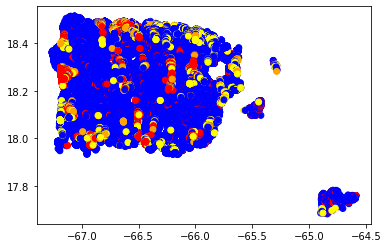

In [20]:
maria = g.loc[g['EVENT_NAME'] == 'Hurricane Maria']

color_dict = {'AFF':'blue', 'MIN':'yellow', 'MAJ':'orange', 'DES':'red'} #classifiers: affected, minimum, major, destruction
plt.scatter(maria.geometry.x,maria.geometry.y,color=[color_dict[i] for i in maria.DMG_LEVEL])

## 3 - Importing high-res aerial imagery

In [21]:
import rasterio
tiff = rasterio.open("/home/jovyan/DominicaDamageAssessment/Aerial/RoseauCentral_4MP.tif")
img = tiff.read()

RasterioIOError: /home/jovyan/DominicaDamageAssessment/Aerial/RoseauCentral_4MP.tif: No such file or directory

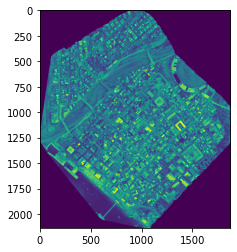

In [14]:
from matplotlib import pyplot
pyplot.imshow(tiff.read(1), cmap='viridis')
pyplot.show()

## 4 - Overlay damage and aerial onto Sentinel map (Pretty useless after this)

In [39]:
aoi_geometry = {
    'type': 'Polygon',
    'coordinates': [[
        [min(settlements.geometry.x),min(settlements.geometry.y)],
        [min(settlements.geometry.x),max(settlements.geometry.y)],
        [max(settlements.geometry.x),max(settlements.geometry.y)],
        [max(settlements.geometry.x),min(settlements.geometry.y)],
        [min(settlements.geometry.x),min(settlements.geometry.y)]
    ]]
}

/opt/conda/lib/python3.7/site-packages/descarteslabs/client/auth/auth.py:397: UserWarning: unable to read token_info from /home/jovyan/.descarteslabs/token_info.json with error Expecting value: line 1 column 1 (char 0).
  self.token_info_path, str(e)


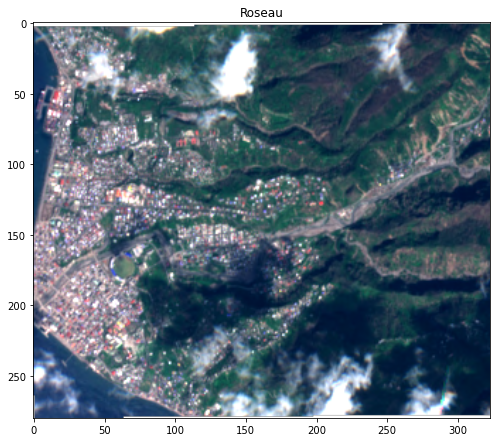

In [48]:
product = "sentinel-2:L1C"

scenes, ctx = dl.scenes.search(
    aoi_geometry,
    products=product,
    start_datetime='2017-10-01',
    end_datetime='2017-11-01',
    cloud_fraction = .06
)

stack = scenes.stack("red green blue", ctx.assign())

composite = np.ma.median(stack, axis=0)
dl.scenes.display(composite, size=7,
                  title="Roseau")



In [26]:
m1 = wf.interactive.MapApp()
m1.center = (15.3050, -61.3787)
m1.zoom = 14

img = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2017-08-15', end_datetime='2017-09-15').pick_bands("red green blue")
img = img.filter(lambda img: img.properties["cloud_fraction"] <= 0.06)
my_mosaic = img.min(axis="images")  #axis='images')
my_mosaic.visualize('before', map=m1) # scales=[(0, 1), (0, 1), (0, 1)],

img2 = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2017-10-01', end_datetime='2017-11-01').pick_bands("red green blue")
img2 = img2.filter(lambda img: img.properties["cloud_fraction"] <= 0.06)
my_mosaic2 = img2.min(axis="images")
my_mosaic2.visualize('after', map=m1) # scales=[(0, 1), (0, 1), (0, 1)],

da = wf.

m1


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [57]:
d = gpd.read_file("/home/jovyan/DominicaDamageAssessment/DDA/Dominica_AOIs_Copernicus.shp")

In [59]:
d

,Site_ID,AgencyID,SiteName,Notes,Area_m2,Area_ha,EventCode,geometry
0,None,Copernicus,AOI3 - South Dominica,None,8.721119e+06,872.111940,EMSR 246,POLYGON ((-61.36590371499994 15.33737778400007...
1,None,Copernicus,AOI3 - South Dominica,None,7.900389e+06,790.038940,EMSR 246,POLYGON ((-61.36544288599993 15.29214048200004...
2,None,Copernicus,AOI3 - South Dominica,None,2.994819e+07,2994.819007,EMSR 246,POLYGON ((-61.36590371499994 15.33737778400007...
3,None,Copernicus,AOI3 - South Dominica,None,2.805200e+07,2805.200479,EMSR 246,POLYGON ((-61.36015291699994 15.29356877000004...
4,None,Copernicus,AOI3 - South Dominica,None,2.819712e+07,2819.712464,EMSR 246,"POLYGON ((-61.2391258909999 15.33508639100006,..."
5,None,Copernicus,AOI3 - South Dominica,None,3.070675e+07,3070.674784,EMSR 246,POLYGON ((-61.24169454199995 15.33539132500005...
6,None,Copernicus,AOI3 - South Dominica,None,6.352550e+06,635.255004,EMSR 246,POLYGON ((-61.37860393699992 15.36796562200004...
7,None,Copernicus,AOI3 - South Dominica,None,9.474521e+06,947.452127,EMSR 246,POLYGON ((-61.37860704399992 15.34280339800006...
8,None,Copernicus,AOI3 - South Dominica,None,7.562664e+05,75.626636,EMSR 246,POLYGON ((-61.36590371499994 15.33737778400007...
9,None,Copernicus,AOI3 - South Dominica,None,1.579611e+06,157.961126,EMSR 246,POLYGON ((-61.36015291699994 15.29356877000004...


In [60]:
e = gpd.read_file("/home/jovyan/DominicaDamageAssessment/DDA/Dominica_AOIs_UNOSAT.shp")

In [61]:
e

,Site_ID,AgencyID,SiteName,Notes,Area_m2,Area_ha,EventCode,geometry
0,Building (General / Default),UNOSAT,Dominica,None,9.082006e+08,90820.056722,TC20170918DMA,"POLYGON ((-61.5100688739999 15.38627682100008,..."
1,Building (General / Default),UNOSAT,Dominica,None,1.629202e+08,16292.022044,TC20170918DMA,POLYGON ((-61.23959206199993 15.20343142800004...


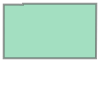

In [64]:
e.geometry[1]

In [74]:
f = gpd.read_file("Dominica_CloudObstruction_Total.shp")
# with open("./Dominica_CloudObstruction_Total.shp") as f:
#     fc = json.load(f)

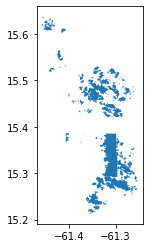

In [78]:
f.geometry.plot()
# for i in range(len(f)):
#     display(f.geometry[i])

In [85]:
image_path = "./b80b37e2-a740-4741-9446-45b039397f4b.tif"
upload = image.upload(image_path)

NameError: name 'image' is not defined

In [93]:
# Create a product
from descarteslabs.catalog import Band, DataType, Product, Resolution, ResolutionUnit, SpectralBand
product = Product(id="guide-example-product", name="Example product")
product.save()

# Set any attributes that should be set on the uploaded images
image = Image(product=product, name="scene1")
image.acquired = "2012-01-02"
image.cloud_fraction = 0.1

# Do the upload
image_path = "./b80b37e2-a740-4741-9446-45b039397f4b.tif"
upload = image.upload(image_path)
upload.wait_for_completion()
upload.status

ConflictError: 
    409: A document with id `cambridge:guide-example-product` already exists

In [99]:
m1.add_layer(image)

AttributeError: 'Image' object has no attribute 'model_id'

In [106]:
image.preview_file